In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import SALib
from SALib.plotting import bar
import seaborn as sns
# read Sobol' sensitivity indices as dataframe
from settings import SOBOL_DATA_DIR, FIGURE_DIR
from utils.Sobol_G_setting import set_sobol_g_func

## Plot Sobol' SA with dummy parameter included

<Figure size 576x432 with 0 Axes>

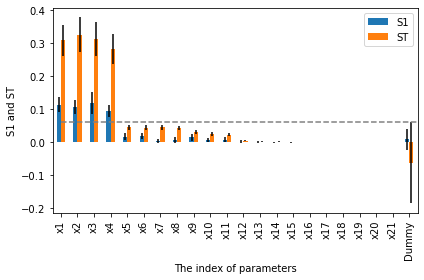

In [4]:
df = pd.read_csv(f'../output/sobol/Sobol_indices.csv', index_col = 'Unnamed: 0')
a, x, x_bounds, x_names, len_params, problem = set_sobol_g_func()

df_plot = pd.DataFrame()
df_plot.loc[:, 'S1'] = df[df.Type == 'S1']['result_5000'].values
df_plot.loc[:, 'S1_conf'] = df[df.Type == 'S1_conf']['result_5000'].values
df_plot.loc[:, 'ST'] = df[df.Type == 'ST']['result_5000'].values
df_plot.loc[:, 'ST_conf'] = df[df.Type == 'ST_conf']['result_5000'].values
threshold = df_plot.loc[21, 'ST'] + df_plot.loc[21, 'ST_conf']

fig = plt.figure(figsize = (8, 6))
ax = bar.plot(df_plot)
ax.set_xticklabels([* problem['names'], 'Dummy'])
ax.set_xlabel('The index of parameters')
ax.set_ylabel('S1 and ST')
plt.tight_layout()
plt.hlines(threshold, xmin=0, xmax=22, colors = 'grey', linestyle='--')
# plt.savefig(f'../output/sobol/Sobol_dummy.png', format = 'png', dpi = 300)

## Plot the adaptive evaluation

In [124]:
pd.read_csv(f'{fpath}{fn}.csv', index_col = 'Unnamed: 0')

,10,20,30,40,50,60,70,80,90,100,...,910,920,930,940,950,960,970,980,990,1000
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.896963,0.775775,0.852604,0.759144,0.732434,0.731014,0.790200,0.789754,0.794102,0.781699,...,0.857561,0.860083,0.858442,0.857338,0.858791,0.859411,0.859247,0.858699,0.857733,0.859361
2,0.955545,0.983542,0.984568,0.983475,0.985552,0.984623,0.963157,0.963679,0.962867,0.963094,...,0.972596,0.972968,0.972614,0.972585,0.973061,0.972973,0.973255,0.973137,0.973443,0.973664
3,0.995322,0.978665,0.986338,0.991636,0.991810,0.991774,0.987923,0.987873,0.986558,0.986682,...,0.992064,0.992173,0.992184,0.992171,0.992106,0.992221,0.992293,0.992283,0.992381,0.992501
4,0.988665,0.991255,0.994113,0.996325,0.997076,0.997220,0.996988,0.996791,0.996555,0.996088,...,0.996930,0.996984,0.997008,0.997020,0.997071,0.997060,0.997014,0.997077,0.997091,0.997085
5,0.999781,0.999563,0.999643,0.999609,0.999666,0.999661,0.999787,0.999788,0.999800,0.999791,...,0.999772,0.999781,0.999778,0.999785,0.999785,0.999778,0.999785,0.999792,0.999785,0.999796
6,0.999986,0.999950,0.999948,0.999940,0.999946,0.999947,0.999957,0.999958,0.999957,0.999958,...,0.999971,0.999971,0.999971,0.999971,0.999971,0.999971,0.999972,0.999972,0.999973,0.999972


In [7]:
from settings import *
df = {}
fpath = '../output/morris/adaptive/'
for fn in METRIC_NAME:
    df[fn] = pd.read_csv(f'{fpath}{fn}.csv', index_col = 'Unnamed: 0').iloc[[0, 1, 3, 5]].T.iloc[0:10]
    # df = df.iloc[5:]

mse = pd.read_csv(f'{fpath}mse.csv', index_col='Unnamed: 0')

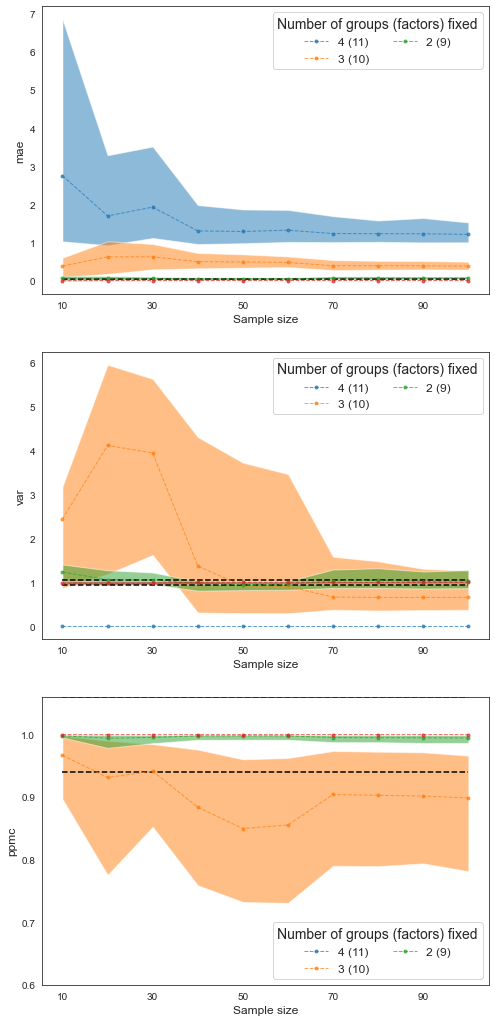

In [17]:
metrics = [fn for fn in METRIC_NAME if not '_' in fn ]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))
fs = 12
lgd = ['4 (11)', '3 (10)', '2 (9)'] # '6 (21)', '5 (17)', '4 (10)', '2 (6)'
sns.set_style('white')
plt.rcParams['legend.title_fontsize'] = 14
for ii in range(len(metrics)):
    metric = metrics[ii]
    ax = df[metric].plot(kind='line', marker='o', linewidth=1, style='--', ms=3, ax = axes[ii], alpha=0.7)
    cols = df[metric].columns
    for col in cols:
        ax.fill_between(df[metric].index, df[f'{metric}_lower'].loc[:, col], df[f'{metric}_upper'].loc[:, col], alpha = 0.5)
    if ii == 0:
        ax.hlines(0.06, df[metric].index[0], df[metric].index[-1], linestyle = '--')
    else:
        ax.hlines(1.06, df[metric].index[0], df[metric].index[-1], linestyle = '--')
        ax.hlines(0.94, df[metric].index[0], df[metric].index[-1], linestyle = '--')
    ax.set_xlabel('Sample size', fontsize=fs);
    ax.set_ylabel(metric, fontsize = fs);
    if metric == 'ppmc':
        ax.legend(lgd, title='Number of groups (factors) fixed', fontsize = fs, ncol=2, loc='lower right') #bbox_to_anchor = (1, 0.95), 
        ax.set_ylim(0.6, 1.06)
    else:
        ax.legend(lgd, title='Number of groups (factors) fixed', fontsize = fs, ncol=2)
plt.savefig('../output/figure/metric_adaptive_100.png', format = 'png', dpi = 300)  

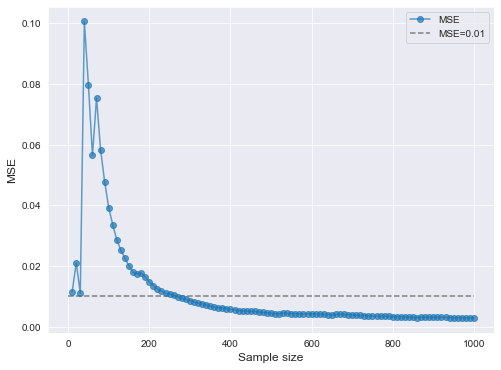

In [112]:
# Plot the MSE of the mean using variance and the sample size
sns.set_style('darkgrid')
ax = mse.plot(legend=False, figsize = (8, 6), marker = 'o', alpha = 0.7)
ax.set_xlabel('Sample size', fontsize=fs)
ax.set_ylabel('MSE', fontsize=fs)
plt.hlines(0.01, xmin=0, xmax=1000, colors='grey', linestyles='--')
ax.legend(['MSE', 'MSE=0.01'])
plt.savefig('../output/figure/mse.png', format = 'png', dpi = 300)

In [115]:
df

{'mae':             0         1         3         5
 10   2.758649  0.392420  0.075625  0.010129
 20   1.705625  0.634049  0.074645  0.014954
 30   1.935654  0.636456  0.069390  0.014739
 40   1.313406  0.507516  0.055093  0.014770
 50   1.298142  0.502099  0.062445  0.014478
 60   1.331249  0.488326  0.061819  0.014386
 70   1.243236  0.401385  0.077529  0.014249
 80   1.240610  0.404496  0.078067  0.014507
 90   1.238129  0.400063  0.078391  0.013981
 100  1.221557  0.393575  0.080584  0.014311,
 'var':        0         1         3         5
 10   0.0  2.440081  1.233551  0.979173
 20   0.0  4.112027  1.059641  0.976676
 30   0.0  3.937403  1.053031  0.977932
 40   0.0  1.369099  0.974243  1.006846
 50   0.0  0.919736  0.948653  1.001747
 60   0.0  0.907086  0.956243  1.001812
 70   0.0  0.664602  1.032729  1.000495
 80   0.0  0.658108  1.043916  1.001501
 90   0.0  0.656559  1.016947  0.998852
 100  0.0  0.660260  1.028116  1.000307,
 'ppmc':       0         1         3         5
 1